In [1]:
%pip install scikit-learn-extra

     |████████████████████████████████| 1.7MB 5.4MB/s 
     |████████████████████████████████| 22.3MB 1.1MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn_extra.cluster import KMedoids
from scipy import ndimage
import tensorflow as tf
import os
import os.path
import random
import shutil
import hashlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
from torch.utils.model_zoo import tqdm
import tarfile
import zipfile
import torchvision
from torch import Tensor
from torchvision import datasets
from torchvision.datasets import SBDataset, CIFAR10
from torchvision import transforms
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
from PIL import Image
from tqdm.auto import tqdm
from collections import OrderedDict
from typing import Any, List, Tuple, Optional, Callable, Dict, TypeVar, Iterable
import torch.optim as optim
from vision import *
from utils import *

random.seed(0)

In [3]:
# Function to convert PIL images to Tensors. We can pass this as a transform to the Dataset
def PIL_to_tensor(img, target):
  return transforms.ToTensor()(img), transforms.ToTensor()(target)

In [4]:
def download_extract(url: str, root: str, filename: str, md5: str) -> None:
    download_url(url, root, filename, md5)
    with tarfile.open(os.path.join(root, filename), "r") as tar:
        tar.extractall(path=root)

# Remember to upload vision.py and utils.py

In [5]:
class CustomSBDataset(VisionDataset):
    """`Semantic Boundaries Dataset <http://home.bharathh.info/pubs/codes/SBD/download.html>`_

    Args:
        root (string): Root directory of the Semantic Boundaries Dataset
        image_set (string, optional): Select the image_set to use, ``train``, ``val`` or ``train_noval``.
            Image set ``train_noval`` excludes VOC 2012 val images.
        mode (string, optional): Select target type. Possible values 'boundaries' or 'segmentation'.
            In case of 'boundaries', the target is an array of shape `[num_classes, H, W]`,
            where `num_classes=20`.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transforms (callable, optional): A function/transform that takes input sample and its target as entry
            and returns a transformed version. Input sample is PIL image and target is a numpy array
            if `mode='boundaries'` or PIL image if `mode='segmentation'`.
    """

    url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz"
    md5 = "82b4d87ceb2ed10f6038a1cba92111cb"
    filename = "benchmark.tgz"

    voc_train_url = "http://home.bharathh.info/pubs/codes/SBD/train_noval.txt"
    voc_split_filename = "train_noval.txt"
    voc_split_md5 = "79bff800c5f0b1ec6b21080a3c066722"

    def __init__(
            self,
            root: str,
            image_set: str = "train",
            mode: str = "segmentation",
            download: bool = False,
            img_filter_size = 200,
            transforms: Optional[Callable] = None,
    ) -> None:

        try:
            from scipy.io import loadmat
            self._loadmat = loadmat
        except ImportError:
            raise RuntimeError("Scipy is not found. This dataset needs to have scipy installed: "
                               "pip install scipy")

        super(CustomSBDataset, self).__init__(root, transforms)
        self.image_set = verify_str_arg(image_set, "image_set",
                                        ("train", "val", "train_noval"))
        self.mode = verify_str_arg(mode, "mode", ("segmentation", "boundaries"))
        self.num_classes = 20
        self.img_filter_size = img_filter_size

        sbd_root = self.root
        image_dir = os.path.join(sbd_root, 'img')
        mask_dir = os.path.join(sbd_root, 'inst')

        if download:
            self.download_dataset(sbd_root)

        if not os.path.isdir(sbd_root):
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')
            
        self.load_filenames(sbd_root, image_dir, mask_dir, image_set)

        self._get_target = self._get_segmentation_target \
            if self.mode == "segmentation" else self._get_boundaries_target

        #self.filter_images()
        self.remove_images_without_mask()

    def _get_segmentation_target(self, filepath: str) -> Image.Image:
        mat = self._loadmat(filepath)
        return Image.fromarray(mat['GTinst'][0]['Segmentation'][0])

    def _get_boundaries_target(self, filepath: str) -> np.ndarray:
        mat = self._loadmat(filepath)
        return np.concatenate([np.expand_dims(mat['GTinst'][0]['Boundaries'][0][i][0].toarray(), axis=0)
                               for i in range(self.num_classes)], axis=0)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = Image.open(self.images[index]).convert('RGB')
        target = self._get_target(self.masks[index])

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        img = transforms.ToTensor()(img)
        target = (transforms.ToTensor()(target)*255)
        target = self.naive_ignore_multiple_object_instances(target)
        img, target = self.center_crop(img, target)
        img = transforms.Resize((480, 480))(img)
        target = transforms.Resize((480, 480))(target)

        return img, target

    def __len__(self) -> int:
        return len(self.images)

    def extra_repr(self) -> str:
        lines = ["Image set: {image_set}", "Mode: {mode}"]
        return '\n'.join(lines).format(**self.__dict__)

    def download_dataset(self, sbd_root) -> None:
        download_extract(self.url, self.root, self.filename, self.md5)
        extracted_ds_root = os.path.join(self.root, "benchmark_RELEASE", "dataset")

        for f in ["cls", "img", "inst", "train.txt", "val.txt"]:
            old_path = os.path.join(extracted_ds_root, f)
            shutil.move(old_path, sbd_root)
        download_url(self.voc_train_url, sbd_root, self.voc_split_filename,
                      self.voc_split_md5)
        
    def load_filenames(self, sbd_root, image_dir, mask_dir, image_set) -> None:
        split_f = os.path.join(sbd_root, image_set.rstrip('\n') + '.txt')

        with open(os.path.join(split_f), "r") as fh:
            file_names = [x.strip() for x in fh.readlines()]

        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.masks = [os.path.join(mask_dir, x + ".mat") for x in file_names]
        assert (len(self.images) == len(self.masks))
        
    # Remove images with both height and width lower than img_filter_size
    def filter_images(self):
        img_to_remove = set()
        for i in range(len(self.images)):
            img = Image.open(self.images[i])
            width, height = img.size
            if width < self.img_filter_size or height < self.img_filter_size:
                img_to_remove.add(i)

        self.images = [img for index, img in enumerate(self.images) if index not in img_to_remove]
        self.masks = [mask for index, mask in enumerate(self.masks) if index not in img_to_remove]

    # Remove images that dont have an instance mask
    def remove_images_without_mask(self):
        img_to_remove = set()
        for i in range(len(self.images)):
            img, target = self.__getitem__(i)
            if torch.count_nonzero(target) < 1000:
              img_to_remove.add(i)
            if torch.count_nonzero(torch.logical_not(target)) < 3000:
              img_to_remove.add(i)

        self.images = [img for index, img in enumerate(self.images) if index not in img_to_remove]
        self.masks = [mask for index, mask in enumerate(self.masks) if index not in img_to_remove]

    # For targets that have multiple object instances, pick label 1 as foreground and let the others be part of the background
    def naive_ignore_multiple_object_instances(self, target):
        cond = torch.eq(target, torch.ones_like(target))
        target = torch.where(cond, target, torch.zeros_like(target))
        return target

    # Apply CenterCrop to image to make it a square based on its smaller dimension
    def center_crop(self, image, target):
      min_len = min(image.shape[1], image.shape[2])
      image = transforms.CenterCrop(min_len)(image)
      target = transforms.CenterCrop(min_len)(target)
      return image, target

    # Apply Random Crop on Image & Target while keeping most of the object instance inside the crop
    def random_crop(self, image, target):
      left = -1
      right = -1
      top = -1
      bottom = -1

      # Find the extreme points of the object instance in the target
      res = torch.nonzero(target[0])
      values, indices = torch.min(res, 0)
      top = values[0].item()
      left = values[1].item()
      values, indices = torch.max(res, 0)
      bottom = values[0].item()
      right = values[1].item()

      # Calculate range to sample top left crop point from
      if right - left >= self.img_filter_size:
        x_min = (right - left)//2
        x_max = (right - left)//2
      else:
        x_min = min(0, right - self.img_filter_size)
        x_max = left

      if bottom - top >= self.img_filter_size:
        y_min = (bottom - top)//2
        y_max = (bottom - top)//2
      else:
        y_min = min(0, bottom - self.img_filter_size)
        y_max = top

      # Sample top left crop point
      x = random.randint(x_min, x_max)
      y = random.randint(y_min, y_max)

      # Apply same random crop to both image and target
      image = transforms.functional.crop(image, y, x, self.img_filter_size, self.img_filter_size)
      target = transforms.functional.crop(target, y, x, self.img_filter_size, self.img_filter_size)

      return image, target

In [6]:
# Download the training set
sbd = CustomSBDataset(root=".", image_set="train", mode="segmentation", download=False)

In [ ]:
# Download the validation Dataset
sbd_val = CustomSBDataset(root=".", image_set="val", mode="segmentation", download=False)

In [7]:
# Check img and target shape
img, target = sbd.__getitem__(0)
print(img.shape, target.shape, sbd.__len__())

torch.Size([3, 480, 480]) torch.Size([1, 480, 480]) 7993


In [ ]:
# Code to display image and segmentation mask. Set images to be num of image, segmentation masks to display
images = 10
fig,axes = plt.subplots(nrows = images, ncols = 2, figsize=(50,50))

for i in range(images):
    img, target = sbd.__getitem__(i)
    axes[i,0].imshow(transforms.ToPILImage()(img))
    axes[i,1].imshow(transforms.ToPILImage()(target))

plt.show()

In [8]:
# Sample user clicks using target
def gen_clicks(target):
  num_pos = random.randint(1, 10)
  num_neg = random.randint(0, 10)

  pos_clicks = gen_pos_clicks(target, num_pos)
  neg_clicks = gen_neg_clicks(target, num_neg)

  return pos_clicks, neg_clicks

# Generate n +ve clicks by randomly sampling points in the foreground
def gen_pos_clicks(target, n):
  pos_clicks = torch.empty((0, 2))
  dstep = 5
  dmargin = 5

  distances = ndimage.distance_transform_edt(target[0].detach().cpu().numpy())
  distances = np.where(distances < dmargin, 0, distances)
  points = torch.nonzero(torch.from_numpy(distances))
  if len(points) == 0:
    print("Pos: {}".format(torch.count_nonzero(target[0])))

  for i in range(n):
    resample = 1
    while (resample > 0 and resample < 4):
      index = random.randint(0, len(points)-1)
      point = points[index]
      if len(pos_clicks) == 0:
        pos_clicks = torch.cat((pos_clicks, point.unsqueeze(0)))
        resample = 0
        break
      else:
        min_dist = dstep
        for pos in pos_clicks:
          dist = torch.dist(point.type(torch.FloatTensor), pos.type(torch.FloatTensor), 2)
          if dist < min_dist:
            min_dist = dist
            break
        if min_dist >= dstep:
          pos_clicks = torch.cat((pos_clicks, point.unsqueeze(0)))
          resample = 0
          break
        resample += 1

  return pos_clicks

# Generate n -ve clicks by randomly sampling points in the background
def gen_neg_clicks(target, n):
  neg_clicks = torch.empty((0, 2))
  dstep = 5
  dmargin_min = 5
  dmargin_max = 50

  target_inv = torch.logical_not(target[0])
  distances = ndimage.distance_transform_edt(target_inv.detach().cpu().numpy())
  distances = np.where(distances < dmargin_min, 0, distances)
  distances = np.where(distances > dmargin_max, 0, distances)
  points = torch.nonzero(torch.from_numpy(distances))
  if len(points) == 0:
    print("Neg: {}".format(torch.count_nonzero(target_inv)))

  for i in range(n):
    resample = 1
    while (resample > 0 and resample < 4):
      index = random.randint(0, len(points)-1)
      point = points[index]
      if len(neg_clicks) == 0:
        neg_clicks = torch.cat((neg_clicks, point.unsqueeze(0)))
        resample = 0
        break
      else:
        min_dist = dstep
        for neg in neg_clicks:
          dist = torch.dist(point.type(torch.FloatTensor), neg.type(torch.FloatTensor), 2)
          if dist < min_dist:
            min_dist = dist
            break
        if min_dist >= dstep:
          neg_clicks = torch.cat((neg_clicks, point.unsqueeze(0)))
          resample = 0
          break
        resample += 1

  return neg_clicks

In [9]:
# Sample user clicks using target
def gen_clicks_2(target):
  num_pos = random.randint(1, 10)
  num_neg = random.randint(0, 10)
  pos_clicks = torch.empty((0, 2))
  neg_clicks = torch.empty((0, 2))

  for i in range(num_pos):
    pos_clicks = gen_pos_click(target, pos_clicks)
  for i in range(num_neg):
    neg_clicks = gen_neg_click(target, neg_clicks)

  return pos_clicks, neg_clicks

# Generates a +ve clicks by randomly sampling points in the foreground
def gen_pos_click(target, pos_clicks):
  dstep = 5
  dmargin = 5

  distances = ndimage.distance_transform_edt(target[0].detach().cpu().numpy())
  distances = np.where(distances < dmargin, 0, distances)
  points = torch.nonzero(torch.from_numpy(distances))
  if len(points) == 0:
    print("Pos: {}".format(torch.count_nonzero(target[0])))

  resample = 1
  while (resample > 0 and resample < 4):
    index = random.randint(0, len(points)-1)
    point = points[index]
    if len(pos_clicks) == 0:
      pos_clicks = torch.cat((pos_clicks, point.unsqueeze(0)))
      resample = 0
      break
    else:
      min_dist = dstep
      for pos in pos_clicks:
        dist = torch.dist(point.type(torch.FloatTensor), pos.type(torch.FloatTensor), 2)
        if dist < min_dist:
          min_dist = dist
          break
      if min_dist >= dstep:
        pos_clicks = torch.cat((pos_clicks, point.unsqueeze(0)))
        resample = 0
        break
      resample += 1

  return pos_clicks

# Generates a -ve click by randomly sampling points in the background
def gen_neg_click(target, neg_clicks):
  dstep = 5
  dmargin_min = 5
  dmargin_max = 50

  target_inv = torch.logical_not(target[0])
  distances = ndimage.distance_transform_edt(target_inv.detach().cpu().numpy())
  distances = np.where(distances < dmargin_min, 0, distances)
  distances = np.where(distances > dmargin_max, 0, distances)
  points = torch.nonzero(torch.from_numpy(distances))
  if len(points) == 0:
    print("Neg: {}".format(torch.count_nonzero(target_inv)))

  resample = 1
  while (resample > 0 and resample < 4):
    index = random.randint(0, len(points)-1)
    point = points[index]
    if len(neg_clicks) == 0:
      neg_clicks = torch.cat((neg_clicks, point.unsqueeze(0)))
      resample = 0
      break
    else:
      min_dist = dstep
      for neg in neg_clicks:
        dist = torch.dist(point.type(torch.FloatTensor), neg.type(torch.FloatTensor), 2)
        if dist < min_dist:
          min_dist = dist
          break
      if min_dist >= dstep:
        neg_clicks = torch.cat((neg_clicks, point.unsqueeze(0)))
        resample = 0
        break
      resample += 1

  return neg_clicks

In [10]:
"""
Convert clicks to interaction maps
Input:
  pos_clicks: list of x,y +ve click locations 
  neg_clicks: list of x,y -ve click locations
Output:
  interaction_map: Concatenation of +ve & -ve maps
  click_location: Tensor with 1's wherever there is a click
  click_type: Tensor with 1 wherever there is a +ve click and 0 wherever there is a -ve click
""" 
def convert_clicks(pos_clicks, neg_clicks):
  pos_map = torch.ones((480, 480))
  neg_map = torch.ones((480, 480))
  click_location = torch.zeros((480, 480))
  click_type = torch.zeros((480, 480))

  for click in pos_clicks:
    pos_map[int(click[0])][int(click[1])] = 0
    click_location[int(click[0])][int(click[1])] = 1
    click_type[int(click[0])][int(click[1])] = 1
  pos_map = ndimage.distance_transform_edt(pos_map.detach().cpu().numpy())
  pos_map = np.where(pos_map > 255, 255, pos_map)
  pos_map = torch.from_numpy(pos_map).unsqueeze(0)
  
  if len(neg_clicks) > 0:
    for click in neg_clicks:
      neg_map[int(click[0])][int(click[1])] = 0
      click_location[int(click[0])][int(click[1])] = 1
      click_type[int(click[0])][int(click[1])] = 0
    neg_map = ndimage.distance_transform_edt(neg_map.detach().cpu().numpy())
    neg_map = np.where(neg_map > 255, 255, neg_map)
    neg_map = torch.from_numpy(neg_map).unsqueeze(0)
  else:
    neg_map = neg_map*255
    neg_map = neg_map.unsqueeze(0)

  click_location = click_location.unsqueeze(0)
  click_type = click_type.unsqueeze(0)
  interaction_map = torch.cat((pos_map, neg_map), 0)

  return interaction_map, click_location, click_type

tensor([[137., 257.],
        [103., 412.],
        [225., 344.],
        [ 37., 433.],
        [ 75., 351.]])
tensor([[388., 363.],
        [249.,  64.],
        [253., 393.]])


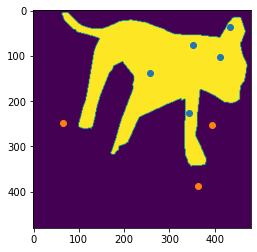

In [ ]:
# Code to test click generation by ploting clicks and segmentation mask
img, target = sbd.__getitem__(4)
pos_clicks = gen_pos_clicks(target, 5)
print(pos_clicks)
neg_clicks = gen_neg_clicks(target, 3)
print(neg_clicks)
plt.imshow(transforms.ToPILImage()(target))
plt.scatter(pos_clicks[:, 1], pos_clicks[:, 0])
plt.scatter(neg_clicks[:, 1], neg_clicks[:, 0])

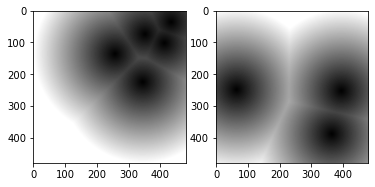

In [ ]:
# Code to visualize interaction maps
iact_map, click_location, click_type = convert_clicks(pos_clicks, neg_clicks)
fig,axes = plt.subplots(nrows = 1, ncols = 2)
axes[0].imshow(iact_map[0].numpy(), cmap='gray', interpolation='bicubic', vmin=0, vmax=255)
axes[1].imshow(iact_map[1].numpy(), cmap='gray', interpolation='bicubic', vmin=0, vmax=255)
plt.show()

In [32]:
"""
DenseNet Encoder Network
"""

model_urls = {
    'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet161': 'https://download.pytorch.org/models/densenet161-8d451a50.pth',
}

BOTTLENECK_WIDTH = 128
COEFF = 12.0

def lip2d(x, logit, kernel=3, stride=2, padding=1):
    weight = logit.exp()
    return F.avg_pool2d(x*weight, kernel, stride, padding)/F.avg_pool2d(weight, kernel, stride, padding)


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class SoftGate(nn.Module):
    def forward(self, x):
        return torch.sigmoid(x).mul(COEFF)


class BottleneckLIP(nn.Module):
    def __init__(self, channels):
        super(BottleneckLIP, self).__init__()

        rp = BOTTLENECK_WIDTH

        self.logit = nn.Sequential(
            OrderedDict((
                ('conv1', conv1x1(channels, rp)),
                ('bn1', nn.InstanceNorm2d(rp, affine=True)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', conv3x3(rp, rp)),
                ('bn2', nn.InstanceNorm2d(rp, affine=True)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', conv1x1(rp, channels)),
                ('bn3', nn.InstanceNorm2d(channels, affine=True)),
                ('gate', SoftGate()),
            ))
        )

    def init_layer(self):
        self.logit[6].weight.data.fill_(0)

    def forward(self, x):
        frac = lip2d(x, self.logit(x), kernel=2, stride=2, padding=0)
        return frac


class SimplifiedLIP(nn.Module):
    def __init__(self, channels):
        super(SimplifiedLIP, self).__init__()

        self.logit = nn.Sequential(
            OrderedDict((
                ('conv1', conv3x3(channels, channels)),
                ('bn1', nn.InstanceNorm2d(channels, affine=True)),
                ('gate', SoftGate()),
            ))
        )

    def init_layer(self):
        self.logit[0].weight.data.fill_(0)

    def forward(self, x):
        frac = lip2d(x, self.logit(x), kernel=3, stride=2, padding=1)
        return frac


class ASPP(nn.Module):
    def __init__(self):
      super(ASPP, self).__init__()

      self.conv_1x1_1 = nn.Conv2d(1024, 256, kernel_size=1)
      self.bn_conv_1x1_1 = nn.BatchNorm2d(256)

      self.conv_3x3_1 = nn.Conv2d(1024, 256, kernel_size=3, stride=1, padding=6, dilation=6)
      self.bn_conv_3x3_1 = nn.BatchNorm2d(256)

      self.conv_3x3_2 = nn.Conv2d(1024, 256, kernel_size=3, stride=1, padding=12, dilation=12)
      self.bn_conv_3x3_2 = nn.BatchNorm2d(256)

      self.conv_3x3_3 = nn.Conv2d(1024, 256, kernel_size=3, stride=1, padding=18, dilation=18)
      self.bn_conv_3x3_3 = nn.BatchNorm2d(256)

      self.conv_3x3_4 = nn.Conv2d(1024, 256, kernel_size=3, stride=1, padding=24, dilation=24)
      self.bn_conv_3x3_4 = nn.BatchNorm2d(256)

      self.avg_pool = nn.AdaptiveAvgPool2d(1)

      self.conv_1x1_2 = nn.Conv2d(1024, 256, kernel_size=1)
      self.bn_conv_1x1_2 = nn.BatchNorm2d(256)

      self.conv_1x1_3 = nn.Conv2d(1280, 256, kernel_size=1)
      self.bn_conv_1x1_3 = nn.BatchNorm2d(256)

      self.conv_1x1_4 = nn.Conv2d(256, 1024, kernel_size=1)

    def forward(self, feature_map):
      # feature_map from DenseBlock4 has shape (batch_size, 1024, 15, 15)

      feature_map_h = feature_map.size()[2]
      feature_map_w = feature_map.size()[3] 

      out_1x1 = F.relu(self.bn_conv_1x1_1(self.conv_1x1_1(feature_map))) # (shape: (batch_size, 256, 15, 15))
      out_3x3_1 = F.relu(self.bn_conv_3x3_1(self.conv_3x3_1(feature_map))) # (shape: (batch_size, 256, 15, 15))
      out_3x3_2 = F.relu(self.bn_conv_3x3_2(self.conv_3x3_2(feature_map))) # (shape: (batch_size, 256, 15, 15))
      out_3x3_3 = F.relu(self.bn_conv_3x3_3(self.conv_3x3_3(feature_map))) # (shape: (batch_size, 256, 15, 15))
      #out_3x3_4 = F.relu(self.bn_conv_3x3_4(self.conv_3x3_4(feature_map))) # (shape: (batch_size, 256, 15, 15))

      out_img = self.avg_pool(feature_map) # (shape: (batch_size, 1024, 1, 1))
      #out_img = F.relu(self.bn_conv_1x1_2(self.conv_1x1_2(out_img))) # (shape: (batch_size, 256, 1, 1))
      out_img = F.relu(self.conv_1x1_2(out_img)) # (shape: (batch_size, 256, 1, 1))
      out_img = F.interpolate(out_img, size=(feature_map_h, feature_map_w), mode="bilinear") # (shape: (batch_size, 256, 15, 15))

      out = torch.cat([out_1x1, out_3x3_1, out_3x3_2, out_3x3_3, out_img], 1) # (shape: (batch_size, 1280, 15, 15))
      out = F.relu(self.bn_conv_1x1_3(self.conv_1x1_3(out))) # (shape: (batch_size, 256, 15, 15))
      out = self.conv_1x1_4(out) # (shape: (batch_size, 1024, 15, 15))

      return out


class SemanticSupervisionBlock(nn.Module):
    def __init__(self, channels, num_classes):
      super(SemanticSupervisionBlock, self).__init__()
      self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
      self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
      self.avg_pool = nn.AdaptiveAvgPool2d(1)
      self.linear1 = nn.Linear(channels, channels//2)
      self.linear2 = nn.Linear(channels//2, num_classes)

    def forward(self, feature_map):
      out = self.conv1(feature_map)
      out = self.conv2(out)
      out = self.avg_pool(out)
      out = torch.flatten(out, 1)
      out = self.linear1(out)
      out = self.linear2(out)
      return out


class _DenseLayer(nn.Module):
    def __init__(
        self,
        num_input_features: int,
        growth_rate: int,
        bn_size: int,
        drop_rate: float
    ) -> None:
        super(_DenseLayer, self).__init__()
        self.norm1: nn.BatchNorm2d
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.relu1: nn.ReLU
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.conv1: nn.Conv2d
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False))
        self.norm2: nn.BatchNorm2d
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.relu2: nn.ReLU
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.conv2: nn.Conv2d
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False))
        self.drop_rate = float(drop_rate)

    def bn_function(self, inputs: List[Tensor]) -> Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))
        return bottleneck_output

    def forward(self, input: Tensor) -> Tensor:
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float
    ) -> None:
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features: Tensor) -> Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int, include_lip: bool) -> None:
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        if include_lip:
          self.add_module('pool', BottleneckLIP(num_output_features))
        else:
          self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    """Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        include_aspp (bool) - Use ASPP block
        include_lip (bool) - Use LIP
        include_ss (bool) - Use Semantic Supervision Block
    """

    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 1000,
        include_aspp: bool = False,
        include_lip: bool = False,
        include_ss: bool = False
    ) -> None:

        super(DenseNet, self).__init__()
        self.include_aspp = include_aspp
        self.include_ss = include_ss

        # First convolution
        if include_lip:
          self.features = nn.Sequential(OrderedDict([
              ('conv0', nn.Conv2d(5, num_init_features,
                                  kernel_size=7, stride=2, padding=3, bias=False)),
              ('norm0', nn.BatchNorm2d(num_init_features)),
              ('relu0', nn.ReLU(inplace=True)),
              ('pool0', SimplifiedLIP(num_init_features)),
          ]))

        else:
          self.features = nn.Sequential(OrderedDict([
              ('conv0', nn.Conv2d(5, num_init_features, kernel_size=7, stride=2,
                                  padding=3, bias=False)),
              ('norm0', nn.BatchNorm2d(num_init_features)),
              ('relu0', nn.ReLU(inplace=True)),
              ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
          ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2, include_lip=include_lip)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Semantic Supervision Blocks
        self.ss1 = SemanticSupervisionBlock(256, num_classes)
        self.ss2 = SemanticSupervisionBlock(512, num_classes)
        self.ss3 = SemanticSupervisionBlock(1024, num_classes)
        
        # ASPP Block
        self.aspp = ASPP()

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        # First Convolution
        x = self.features.conv0(x)
        x = self.features.norm0(x)
        x = self.features.relu0(x)
        x = self.features.pool0(x)

        # Dense Blocks
        dense1_out = self.features.denseblock1(x)
        x = self.features.transition1(dense1_out)
        dense2_out = self.features.denseblock2(x)
        x = self.features.transition2(dense2_out)
        dense3_out = self.features.denseblock3(x)
        x = self.features.transition3(dense3_out)
        dense4_out = self.features.denseblock4(x)
        
        # Semantic Supervision
        if self.include_ss:
          ss1_out = self.ss1(dense1_out)
          ss2_out = self.ss2(dense2_out)
          ss3_out = self.ss3(dense3_out)

        # ASPP
        if self.include_aspp:
          dense4_out = self.aspp(dense4_out);

        out = self.features.norm5(dense4_out)
        out = F.relu(out, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)

        dense_out = [dense1_out, dense2_out, dense3_out, dense4_out]
        if self.include_ss:
          ss_out = [ss1_out, ss2_out, ss3_out]
        else:
          ss_out = []
        return out, dense_out, ss_out


def _load_state_dict(model: nn.Module, model_url: str, progress: bool) -> None:
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)


def _densenet(
    arch: str,
    growth_rate: int,
    block_config: Tuple[int, int, int, int],
    num_init_features: int,
    pretrained: bool,
    progress: bool,
    include_aspp: bool,
    include_lip: bool,
    include_ss: bool,
    **kwargs: Any
) -> DenseNet:
    model = DenseNet(growth_rate, block_config, num_init_features, include_aspp=include_aspp, include_lip=include_lip, include_ss=include_ss, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model


def densenet121(pretrained: bool = False, progress: bool = True, include_aspp: bool = False, include_lip: bool = False, include_ss: bool = False, **kwargs: Any) -> DenseNet:
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress, include_aspp, include_lip, include_ss, **kwargs)

In [15]:
"""
Decoder Network
"""

class Decoder(nn.Module):

  def __init__(self):
    super(Decoder, self).__init__()

    self.conv_SE_1_32_1 = nn.Conv2d(in_channels=1024, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
    self.conv_SE_1_32_2 = nn.Conv2d(in_channels=64, out_channels=1024, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
    self.conv_1_32_1d = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1, bias=False)
    self.prelu_1_32_1d = nn.PReLU(num_parameters=512)
    self.bn_1_32_1d = nn.BatchNorm2d(num_features=512, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_1_32_2d = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1, bias=False)
    self.prelu_1_32_2d = nn.PReLU(num_parameters=512)
    self.bn_1_32_2d = nn.BatchNorm2d(num_features=512, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_1_32_3d = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.prelu_1_32_3d = nn.PReLU(num_parameters=256)
    self.bn_1_32_3d = nn.BatchNorm2d(num_features=256, eps=9.999999747378752e-06, momentum=0.0)
    self.deconv_1_16d = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, bias=False)
    self.prelu_1_16d = nn.PReLU(num_parameters=256)
    self.bn_1_16d = nn.BatchNorm2d(num_features=256, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_SE_1_16_1 = nn.Conv2d(in_channels=1024, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.conv_SE_1_16_2 = nn.Conv2d(in_channels=64, out_channels=1024, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.conv_SE_1_16 = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.prelu_SE_1_16 = nn.PReLU(num_parameters=256)
    self.bn_SE_1_16 = nn.BatchNorm2d(num_features=256, eps=9.999999747378752e-06, momentum=0.0)

    self.conv_1_16_1d = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1, bias=False)
    self.prelu_1_16_1d = nn.PReLU(num_parameters=256)
    self.bn_1_16_1d = nn.BatchNorm2d(num_features=256, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_1_16_2d = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1, bias=False)
    self.prelu_1_16_2d = nn.PReLU(num_parameters=256)
    self.bn_1_16_2d = nn.BatchNorm2d(num_features=256, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_1_16_3d = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.prelu_1_16_3d = nn.PReLU(num_parameters=128)
    self.bn_1_16_3d = nn.BatchNorm2d(num_features=128, eps=9.999999747378752e-06, momentum=0.0)
    self.deconv_1_8d = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, bias=False)
    self.prelu_1_8d = nn.PReLU(num_parameters=128)
    self.bn_1_8d = nn.BatchNorm2d(num_features=128, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_SE_1_8_1 = nn.Conv2d(in_channels=512, out_channels=32, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.conv_SE_1_8_2 = nn.Conv2d(in_channels=32, out_channels=512, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.conv_SE_1_8 = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.prelu_SE_1_8 = nn.PReLU(num_parameters=128)
    self.bn_SE_1_8 = nn.BatchNorm2d(num_features=128, eps=9.999999747378752e-06, momentum=0.0)

    self.conv_1_8_1d = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1, bias=False)
    self.prelu_1_8_1d = nn.PReLU(num_parameters=128)
    self.bn_1_8_1d = nn.BatchNorm2d(num_features=128, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_1_8_2d = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1, bias=False)
    self.prelu_1_8_2d = nn.PReLU(num_parameters=128)
    self.bn_1_8_2d = nn.BatchNorm2d(num_features=128, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_1_8_3d = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.prelu_1_8_3d = nn.PReLU(num_parameters=64)
    self.bn_1_8_3d = nn.BatchNorm2d(num_features=64, eps=9.999999747378752e-06, momentum=0.0)
    self.deconv_1_4d = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, bias=False)
    self.prelu_1_4d = nn.PReLU(num_parameters=64)
    self.bn_1_4d = nn.BatchNorm2d(num_features=64, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_SE_1_4_1 = nn.Conv2d(in_channels=256, out_channels=16, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.conv_SE_1_4_2 = nn.Conv2d(in_channels=16, out_channels=256, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.conv_SE_1_4 = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.prelu_SE_1_4 = nn.PReLU(num_parameters=64)
    self.bn_SE_1_4 = nn.BatchNorm2d(num_features=64, eps=9.999999747378752e-06, momentum=0.0)

    self.conv_1_4_1d = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1, bias=False)
    self.prelu_1_4_1d = nn.PReLU(num_parameters=64)
    self.bn_1_4_1d = nn.BatchNorm2d(num_features=64, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_1_4_2d = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1, bias=False)
    self.prelu_1_4_2d = nn.PReLU(num_parameters=64)
    self.bn_1_4_2d = nn.BatchNorm2d(num_features=64, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_1_4_3d = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.prelu_1_4_3d = nn.PReLU(num_parameters=32)
    self.bn_1_4_3d = nn.BatchNorm2d(num_features=32, eps=9.999999747378752e-06, momentum=0.0)

    self.pred_1_4 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
    self.pred_step_1 = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=4, stride=4, bias=False)

    self.conv_atrous1_1 = nn.Conv2d(in_channels=6, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1, bias=False)
    self.prelu_atrous1_1 = nn.PReLU(num_parameters=32)
    self.bn_atrous1_1 = nn.BatchNorm2d(num_features=32, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_atrous1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1, bias=False)
    self.prelu_atrous1_2 = nn.PReLU(num_parameters=32)
    self.bn_atrous1_2 = nn.BatchNorm2d(num_features=32, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_atrous1_3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.prelu_atrous1_3 = nn.PReLU(num_parameters=16)
    self.bn_atrous1_3 = nn.BatchNorm2d(num_features=16, eps=9.999999747378752e-06, momentum=0.0)

    self.conv_atrous2_1 = nn.Conv2d(in_channels=6, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), groups=1, bias=False)
    self.prelu_atrous2_1 = nn.PReLU(num_parameters=32)
    self.bn_atrous2_1 = nn.BatchNorm2d(num_features=32, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_atrous2_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1, bias=False)
    self.prelu_atrous2_2 = nn.PReLU(num_parameters=32)
    self.bn_atrous2_2 = nn.BatchNorm2d(num_features=32, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_atrous2_3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.prelu_atrous2_3 = nn.PReLU(num_parameters=16)
    self.bn_atrous2_3 = nn.BatchNorm2d(num_features=16, eps=9.999999747378752e-06, momentum=0.0)

    self.conv_atrous3_1 = nn.Conv2d(in_channels=6, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3), groups=1, bias=False)
    self.prelu_atrous3_1 = nn.PReLU(num_parameters=32)
    self.bn_atrous3_1 = nn.BatchNorm2d(num_features=32, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_atrous3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1, bias=False)
    self.prelu_atrous3_2 = nn.PReLU(num_parameters=32)
    self.bn_atrous3_2 = nn.BatchNorm2d(num_features=32, eps=9.999999747378752e-06, momentum=0.0)
    self.conv_atrous3_3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=False)
    self.prelu_atrous3_3 = nn.PReLU(num_parameters=16)
    self.bn_atrous3_3 = nn.BatchNorm2d(num_features=16, eps=9.999999747378752e-06, momentum=0.0)
    
    self.conv_s2_down = nn.Conv2d(in_channels=48, out_channels=3, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
    self.conv_s2_up = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)
    self.conv_p1_1 = nn.Conv2d(in_channels=48, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1, bias=False)
    self.prelu_p1_1 = nn.PReLU(num_parameters=16)
    self.bn_p1_1 = nn.BatchNorm2d(num_features=16, eps=9.999999747378752e-06, momentum=0.0)
    self.pred_step_2 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(1, 1), stride=(1, 1), groups=1, bias=True)

  def forward(self, dense_out):
    concat_input = dense_out[4]
    concat_5_16 = dense_out[3]
    concat_4_24 = dense_out[2]
    concat_3_12 = dense_out[1]
    concat_2_6 = dense_out[0]

    ################ BLOCK 1 ################      
    pool_SE_1_32    = F.avg_pool2d(concat_5_16, kernel_size=(15, 15), stride=(1, 1), padding=(0,), ceil_mode=False, count_include_pad=False)
    conv_SE_1_32_1  = self.conv_SE_1_32_1(pool_SE_1_32)
    relu_SE_1_32_1  = F.relu(conv_SE_1_32_1)
    conv_SE_1_32_2  = self.conv_SE_1_32_2(relu_SE_1_32_1)
    sigm_SE_1_32    = torch.sigmoid(conv_SE_1_32_2)
    reshape_SE_1_32 = torch.reshape(input = sigm_SE_1_32, shape = (1,1024,1,1))
    scale_SE_1_32   = concat_5_16 * reshape_SE_1_32

    conv_1_32_1d    = self.conv_1_32_1d(scale_SE_1_32)
    #prelu_1_32_1d   = F.prelu(conv_1_32_1d, torch.from_numpy(_weights_dict['prelu_1/32_1d']['weights']))
    prelu_1_32_1d   = self.prelu_1_32_1d(conv_1_32_1d)
    bn_1_32_1d      = self.bn_1_32_1d(prelu_1_32_1d)

    conv_1_32_2d    = self.conv_1_32_2d(bn_1_32_1d)
    #prelu_1_32_2d   = F.prelu(conv_1_32_2d, torch.from_numpy(_weights_dict['prelu_1/32_2d']['weights']))
    prelu_1_32_2d   = self.prelu_1_32_2d(conv_1_32_2d)
    bn_1_32_2d      = self.bn_1_32_2d(prelu_1_32_2d)

    conv_1_32_3d    = self.conv_1_32_3d(bn_1_32_2d)
    #prelu_1_32_3d   = F.prelu(conv_1_32_3d, torch.from_numpy(_weights_dict['prelu_1/32_3d']['weights']))
    prelu_1_32_3d   = self.prelu_1_32_3d(conv_1_32_3d)
    bn_1_32_3d      = self.bn_1_32_3d(prelu_1_32_3d)

    deconv_1_16d	  = self.deconv_1_16d(bn_1_32_3d)
    #prelu_1_16d     = F.prelu(deconv_1_16d, torch.from_numpy(_weights_dict['prelu_1/16d']['weights']))
    prelu_1_16d     = self.prelu_1_16d(deconv_1_16d)
    bn_1_16d        = self.bn_1_16d(prelu_1_16d)

    pool_SE_1_16    = F.avg_pool2d(concat_4_24, kernel_size=(30, 30), stride=(1, 1), padding=(0,), ceil_mode=False, count_include_pad=False)
    conv_SE_1_16_1  = self.conv_SE_1_16_1(pool_SE_1_16)
    relu_SE_1_16_1  = F.relu(conv_SE_1_16_1)
    conv_SE_1_16_2  = self.conv_SE_1_16_2(relu_SE_1_16_1)
    sigm_SE_1_16    = torch.sigmoid(conv_SE_1_16_2)
    reshape_SE_1_16 = torch.reshape(input = sigm_SE_1_16, shape = (1,1024,1,1))
    scale_SE_1_16   = concat_4_24 * reshape_SE_1_16
    conv_SE_1_16    = self.conv_SE_1_16(scale_SE_1_16)
    #prelu_SE_1_16    = F.prelu(conv_SE_1_8, torch.from_numpy(_weights_dict['prelu_SE_1/16']['weights']))
    prelu_SE_1_16   = self.prelu_SE_1_16(conv_SE_1_16)
    bn_SE_1_16      = self.bn_SE_1_16(prelu_SE_1_16)
    #########################################

    ################ BLOCK 2 ################
    concat_1_16d    = torch.cat((bn_1_16d, bn_SE_1_16,), 1)

    conv_1_16_1d    = self.conv_1_16_1d(concat_1_16d)
    #prelu_1_16_1d   = F.prelu(conv_1_16_1d, torch.from_numpy(_weights_dict['prelu_1/16_1d']['weights']))
    prelu_1_16_1d   = self.prelu_1_16_1d(conv_1_16_1d)
    bn_1_16_1d      = self.bn_1_16_1d(prelu_1_16_1d)

    conv_1_16_2d    = self.conv_1_16_2d(bn_1_16_1d)
    #prelu_1_16_2d   = F.prelu(conv_1_16_2d, torch.from_numpy(_weights_dict['prelu_1/16_2d']['weights']))
    prelu_1_16_2d   = self.prelu_1_16_2d(conv_1_16_2d)
    bn_1_16_2d      = self.bn_1_16_2d(prelu_1_16_2d)

    conv_1_16_3d    = self.conv_1_16_3d(bn_1_16_2d)
    #prelu_1_16_3d   = F.prelu(conv_1_16_3d, torch.from_numpy(_weights_dict['prelu_1/16_3d']['weights']))
    prelu_1_16_3d   = self.prelu_1_16_3d(conv_1_16_3d)
    bn_1_16_3d      = self.bn_1_16_3d(prelu_1_16_3d)

    deconv_1_8d		= self.deconv_1_8d(bn_1_16_3d)
    #prelu_1_8d      = F.prelu(deconv_1_8d, torch.from_numpy(_weights_dict['prelu_1/8d']['weights']))
    prelu_1_8d      = self.prelu_1_8d(deconv_1_8d)
    bn_1_8d         = self.bn_1_8d(prelu_1_8d)

    pool_SE_1_8     = F.avg_pool2d(concat_3_12, kernel_size=(60, 60), stride=(1, 1), padding=(0,), ceil_mode=False, count_include_pad=False)
    conv_SE_1_8_1   = self.conv_SE_1_8_1(pool_SE_1_8)        
    relu_SE_1_8_1   = F.relu(conv_SE_1_8_1)
    conv_SE_1_8_2   = self.conv_SE_1_8_2(relu_SE_1_8_1)
    sigm_SE_1_8     = torch.sigmoid(conv_SE_1_8_2)
    reshape_SE_1_8  = torch.reshape(input = sigm_SE_1_8, shape = (1,512,1,1))
    scale_SE_1_8    = concat_3_12 * reshape_SE_1_8
    conv_SE_1_8     = self.conv_SE_1_8(scale_SE_1_8)
    #prelu_SE_1_8    = F.prelu(conv_SE_1_8, torch.from_numpy(_weights_dict['prelu_SE_1/8']['weights']))
    prelu_SE_1_8    = self.prelu_SE_1_8(conv_SE_1_8)
    bn_SE_1_8       = self.bn_SE_1_8(prelu_SE_1_8)
    #########################################

    ################ BLOCK 3 ################																
    concat_1_8d     = torch.cat((bn_1_8d, bn_SE_1_8,), 1)

    conv_1_8_1d     = self.conv_1_8_1d(concat_1_8d)
    #prelu_1_8_1d    = F.prelu(conv_1_8_1d, torch.from_numpy(_weights_dict['prelu_1/8_1d']['weights']))
    prelu_1_8_1d    = self.prelu_1_8_1d(conv_1_8_1d)
    bn_1_8_1d       = self.bn_1_8_1d(prelu_1_8_1d)

    conv_1_8_2d     = self.conv_1_8_2d(bn_1_8_1d)
    #prelu_1_8_2d    = F.prelu(conv_1_8_2d, torch.from_numpy(_weights_dict['prelu_1/8_2d']['weights']))
    prelu_1_8_2d    = self.prelu_1_8_2d(conv_1_8_2d)
    bn_1_8_2d       = self.bn_1_8_2d(prelu_1_8_2d)

    conv_1_8_3d     = self.conv_1_8_3d(bn_1_8_2d)
    #prelu_1_8_3d    = F.prelu(conv_1_8_3d, torch.from_numpy(_weights_dict['prelu_1/8_3d']['weights']))
    prelu_1_8_3d    = self.prelu_1_8_3d(conv_1_8_3d)
    bn_1_8_3d       = self.bn_1_8_3d(prelu_1_8_3d)

    deconv_1_4d		= self.deconv_1_4d(bn_1_8_3d)
    #prelu_1_4d      = F.prelu(deconv_1_4d, torch.from_numpy(_weights_dict['prelu_1/4d']['weights']))
    prelu_1_4d      = self.prelu_1_4d(deconv_1_4d)
    bn_1_4d         = self.bn_1_4d(prelu_1_4d)

    pool_SE_1_4     = F.avg_pool2d(concat_2_6, kernel_size=(120, 120), stride=(1, 1), padding=(0,), ceil_mode=False, count_include_pad=False)
    conv_SE_1_4_1   = self.conv_SE_1_4_1(pool_SE_1_4)
    relu_SE_1_4_1   = F.relu(conv_SE_1_4_1)
    conv_SE_1_4_2   = self.conv_SE_1_4_2(relu_SE_1_4_1)
    sigm_SE_1_4     = torch.sigmoid(conv_SE_1_4_2)
    reshape_SE_1_4  = torch.reshape(input = sigm_SE_1_4, shape = (1,256,1,1))
    scale_SE_1_4    = concat_2_6 * reshape_SE_1_4
    conv_SE_1_4     = self.conv_SE_1_4(scale_SE_1_4)
    #prelu_SE_1_4    = F.prelu(conv_SE_1_4, torch.from_numpy(_weights_dict['prelu_SE_1/4']['weights']))
    prelu_SE_1_4    = self.prelu_SE_1_4(conv_SE_1_4)
    bn_SE_1_4       = self.bn_SE_1_4(prelu_SE_1_4)
    #########################################

    ################ BLOCK 4 ################														        
    concat_1_4d     = torch.cat((bn_1_4d, bn_SE_1_4,), 1)

    conv_1_4_1d     = self.conv_1_4_1d(concat_1_4d)
    #prelu_1_4_1d    = F.prelu(conv_1_4_1d, torch.from_numpy(_weights_dict['prelu_1/4_1d']['weights']))
    prelu_1_4_1d    = self.prelu_1_4_1d(conv_1_4_1d)
    bn_1_4_1d       = self.bn_1_4_1d(prelu_1_4_1d)

    conv_1_4_2d     = self.conv_1_4_2d(bn_1_4_1d)
    #prelu_1_4_2d    = F.prelu(conv_1_4_2d, torch.from_numpy(_weights_dict['prelu_1/4_2d']['weights']))
    prelu_1_4_2d    = self.prelu_1_4_2d(conv_1_4_2d)
    bn_1_4_2d       = self.bn_1_4_2d(prelu_1_4_2d)

    conv_1_4_3d     = self.conv_1_4_3d(bn_1_4_2d)
    #prelu_1_4_3d    = F.prelu(conv_1_4_3d, torch.from_numpy(_weights_dict['prelu_1/4_3d']['weights']))
    prelu_1_4_3d    = self.prelu_1_4_3d(conv_1_4_3d)
    bn_1_4_3d       = self.bn_1_4_3d(prelu_1_4_3d)
    #########################################

    ################ PREDICTION AT 1/4 ################
    pred_1_4        = self.pred_1_4(bn_1_4_3d)

    ################ UNSAMPLE THE PREDICTION FROM 1/4 TO 1/1 ################
    pred_step_1 	= self.pred_step_1(pred_1_4)
    sigp_step_1     = torch.sigmoid(pred_step_1)


    ################ SECONDARY NETWORK (FINE DECODER) STARTS HERE ################
    concat_step_1   = torch.cat((concat_input, sigp_step_1,), 1)

    ################ ATROUS POOLING BLOCK 1 ################
    conv_atrous1_1  = self.conv_atrous1_1(concat_step_1)
    #prelu_atrous1_1 = F.prelu(conv_atrous1_1, torch.from_numpy(_weights_dict['prelu_atrous1_1']['weights']))
    prelu_atrous1_1 = self.prelu_atrous1_1(conv_atrous1_1)
    bn_atrous1_1    = self.bn_atrous1_1(prelu_atrous1_1)

    conv_atrous1_2  = self.conv_atrous1_2(bn_atrous1_1)
    #prelu_atrous1_2 = F.prelu(conv_atrous1_2, torch.from_numpy(_weights_dict['prelu_atrous1_2']['weights']))
    prelu_atrous1_2 = self.prelu_atrous1_2(conv_atrous1_2)
    bn_atrous1_2    = self.bn_atrous1_2(prelu_atrous1_2)

    conv_atrous1_3  = self.conv_atrous1_3(bn_atrous1_2)
    #prelu_atrous1_3 = F.prelu(conv_atrous1_3, torch.from_numpy(_weights_dict['prelu_atrous1_3']['weights']))
    prelu_atrous1_3 = self.prelu_atrous1_3(conv_atrous1_3)
    bn_atrous1_3    = self.bn_atrous1_3(prelu_atrous1_3)
    ########################################################

    ################ ATROUS POOLING BLOCK 2 ################
    conv_atrous2_1  = self.conv_atrous2_1(concat_step_1)
    #prelu_atrous2_1 = F.prelu(conv_atrous2_1, torch.from_numpy(_weights_dict['prelu_atrous2_1']['weights']))
    prelu_atrous2_1 = self.prelu_atrous2_1(conv_atrous2_1)
    bn_atrous2_1    = self.bn_atrous2_1(prelu_atrous2_1)

    conv_atrous2_2  = self.conv_atrous2_2(bn_atrous2_1)
    #prelu_atrous2_2 = F.prelu(conv_atrous2_2, torch.from_numpy(_weights_dict['prelu_atrous2_2']['weights']))
    prelu_atrous2_2 = self.prelu_atrous2_2(conv_atrous2_2)
    bn_atrous2_2    = self.bn_atrous2_2(prelu_atrous2_2)

    conv_atrous2_3  = self.conv_atrous2_3(bn_atrous2_2)
    #prelu_atrous2_3 = F.prelu(conv_atrous2_3, torch.from_numpy(_weights_dict['prelu_atrous2_3']['weights']))
    prelu_atrous2_3 = self.prelu_atrous2_3(conv_atrous2_3)
    bn_atrous2_3    = self.bn_atrous2_3(prelu_atrous2_3)
    ########################################################

    ################ ATROUS POOLING BLOCK 3 ################
    conv_atrous3_1  = self.conv_atrous3_1(concat_step_1)
    #prelu_atrous3_1 = F.prelu(conv_atrous3_1, torch.from_numpy(_weights_dict['prelu_atrous3_1']['weights']))
    prelu_atrous3_1 = self.prelu_atrous3_1(conv_atrous3_1)
    bn_atrous3_1    = self.bn_atrous3_1(prelu_atrous3_1)

    conv_atrous3_2  = self.conv_atrous3_2(bn_atrous3_1)
    #prelu_atrous3_2 = F.prelu(conv_atrous3_2, torch.from_numpy(_weights_dict['prelu_atrous3_2']['weights']))
    prelu_atrous3_2 = self.prelu_atrous3_2(conv_atrous3_2)
    bn_atrous3_2    = self.bn_atrous3_2(prelu_atrous3_2)

    conv_atrous3_3  = self.conv_atrous3_3(bn_atrous3_2)
    #prelu_atrous3_3 = F.prelu(conv_atrous3_3, torch.from_numpy(_weights_dict['prelu_atrous3_3']['weights']))
    prelu_atrous3_3 = self.prelu_atrous3_3(conv_atrous3_3)
    bn_atrous3_3    = self.bn_atrous3_3(prelu_atrous3_3)
    ########################################################

    ################ CONCAT + SQUEEZ & EXCITATION ################
    concat_step_2   = torch.cat((bn_atrous1_3, bn_atrous2_3, bn_atrous3_3,), 1)
    gpool_s2        = F.avg_pool2d(concat_step_2, kernel_size=(480, 480), stride=(1, 1), padding=(0,), ceil_mode=False, count_include_pad=False)
    conv_s2_down    = self.conv_s2_down(gpool_s2)
    relu_s2_down    = F.relu(conv_s2_down)
    conv_s2_up      = self.conv_s2_up(relu_s2_down)
    sig_s2_up       = torch.sigmoid(conv_s2_up)
    resh_s2         = torch.reshape(input = sig_s2_up, shape = (1,48,1,1))
    scale_s2        = concat_step_2 * resh_s2
    ##############################################################

    ################ PREDICTION ################
    conv_p1_1       = self.conv_p1_1(scale_s2)
    #prelu_p1_1      = F.prelu(conv_p1_1, torch.from_numpy(_weights_dict['prelu_p1_1']['weights']))
    prelu_p1_1      = self.prelu_p1_1(conv_p1_1)
    bn_p1_1         = self.bn_p1_1(prelu_p1_1)
    pred_step_2     = self.pred_step_2(bn_p1_1)
    ############################################

    ################ PREDICTION ################
    sig_pred        = torch.sigmoid(pred_step_2)
    ############################################
    return sig_pred

    ################ SECONDARY NETWORK (FINE DECORDER) ENDS HERE ################

In [33]:
# Initialise encoder object
encoder = densenet121(include_ss=True).double()

In [34]:
# Initialise decoder
decoder = Decoder().double()

In [35]:
# Test Encoder
img, target = sbd.__getitem__(4)
pos_clicks, neg_clicks = gen_clicks(target)
iact_map, click_location, click_type = convert_clicks(pos_clicks, neg_clicks)
input = torch.cat((img, iact_map), 0)
input = input.unsqueeze(0).double().to(device)
target = target.to(device)
encoder_out, dense_out, ss_out = encoder(input)
dense_out.append(input)

In [37]:
for out in ss_out:
  print(out.shape)
print(encoder_out.shape)

torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])


In [22]:
# Test Decoder
decoder_out = decoder(dense_out)
decoder_out = torch.where(decoder_out > 0.5, 1.0, 0.0)
print(decoder_out.shape)

torch.Size([1, 1, 480, 480])


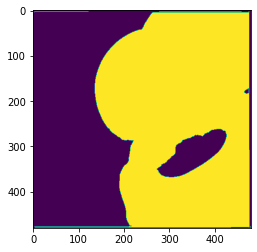

In [23]:
# Visualize Decoder output
plt.imshow(transforms.ToPILImage()(decoder_out[0]))

In [ ]:
# Calculate IOU(intersection Over Union) between output and target
def iou_metric(output, target):
  output = output.squeeze(1)
  
  intersection = (torch.logical_and(output, target)).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
  union = (torch.logical_or(output, target)).float().sum((1, 2))         # Will be zero if both are 0
  
  iou = (intersection + 1e-6) / (union + 1e-6)  # We smooth our division to avoid 0/0
  print(intersection, union)
  
  #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
  
  return iou

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())

cpu
0


In [ ]:
encoder = densenet121().double().to(device)
decoder = Decoder().double().to(device)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.SGD([{'params': encoder.parameters(), 'lr': 1e-9}, {'params': decoder.parameters(), 'lr': 1e-7}], momentum=0.9)

In [ ]:
def train_model(encoder, decoder, dataset, epochs):
  for epoch in range(epochs):

    running_loss = 0.0
    for i in range(dataset.__len__()):
      img, target = dataset.__getitem__(i)
      pos_clicks, neg_clicks = gen_clicks(target)
      iact_map, click_location, click_type = convert_clicks(pos_clicks, neg_clicks)
      input = torch.cat((img, iact_map), 0)
      input = input.unsqueeze(0).double().to(device)
      target = target.to(device)

      optimizer.zero_grad()

      encoder_out, dense_out, ss_out = encoder(input)
      dense_out.append(input)
      decoder_out = decoder(dense_out)   

      loss = criterion(decoder_out, target.unsqueeze(0).double())
      loss.backward()
      optimizer.step() 

      running_loss += loss.item()
      if i % 500 == 0:
        print("{} loss: {:.4f}".format(i, running_loss/(i+1)))
    
    print("{}, loss: {:.4f}".format(epoch, running_loss/dataset.__len__()))

In [ ]:
train_model(encoder, decoder, sbd, 30)

0 loss: 0.7428
500 loss: 0.6298
1000 loss: 0.6278
1500 loss: 0.6269
2000 loss: 0.6255
2500 loss: 0.6244
3000 loss: 0.6231
3500 loss: 0.6233
4000 loss: 0.6236
4500 loss: 0.6236
5000 loss: 0.6240
5500 loss: 0.6238
6000 loss: 0.6235
6500 loss: 0.6229
7000 loss: 0.6226
7500 loss: 0.6219
0, loss: 0.6209
0 loss: 0.6539
500 loss: 0.6102
1000 loss: 0.6066
1500 loss: 0.6059
2000 loss: 0.6050
2500 loss: 0.6045
3000 loss: 0.6032
3500 loss: 0.6032
4000 loss: 0.6036
4500 loss: 0.6037
5000 loss: 0.6044
5500 loss: 0.6043
6000 loss: 0.6040
6500 loss: 0.6035
7000 loss: 0.6035
7500 loss: 0.6030
1, loss: 0.6023
0 loss: 0.7256
500 loss: 0.5946
1000 loss: 0.5924
1500 loss: 0.5917
2000 loss: 0.5914
2500 loss: 0.5912
3000 loss: 0.5904
3500 loss: 0.5900
4000 loss: 0.5903
4500 loss: 0.5904
5000 loss: 0.5908
5500 loss: 0.5908
6000 loss: 0.5905
6500 loss: 0.5902
7000 loss: 0.5904
7500 loss: 0.5902
2, loss: 0.5898
0 loss: 0.6751
500 loss: 0.5808
1000 loss: 0.5785
1500 loss: 0.5774
2000 loss: 0.5785
2500 loss: 0.5

KeyboardInterrupt: 

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((480,480))])

cifar10 = CIFAR10(root=".", train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(cifar10, batch_size=4,
                                          shuffle=True, num_workers=2)

In [ ]:
encoder = densenet121(num_classes=10).double().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(encoder.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Trains the model
def pretrain_model(encoder, dataset, epochs):
  for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      img, target = data
      target = target.to(device)
      #pos_clicks, neg_clicks = gen_clicks(target)
      #iact_map, click_location, click_type = convert_clicks(pos_clicks, neg_clicks)
      iact_map = torch.ones((img.shape[0],2,480,480))
      input = torch.cat((img, iact_map), 1)
      input = input.double().to(device)

      optimizer.zero_grad()

      encoder_out, dense_out, ss_out = encoder(input)
      dense_out.append(input) 

      #loss = criterion(encoder_out, target.unsqueeze(0).double())
      loss = criterion(encoder_out, target)
      loss.backward()
      optimizer.step() 

      running_loss += loss.item()
      if i % 100 == 0:
        print("{} loss: {:.4f}".format(i, running_loss/(i+1)))
    
    print("{}, loss: {:.4f}".format(epoch, running_loss/dataset.__len__()))

In [ ]:
pretrain_model(encoder, cifar10, 1)

In [ ]:
# Save model
torch.save(encoder.state_dict(), "./encoder_dict.pth")
torch.save(decoder.state_dict(), "./decoder_dict.pth")
torch.save(optimizer.state_dict(), "./optimizer_dict.pth")

In [ ]:
# Load Model
encoder.load_state_dict(torch.load("./encoder_dict.pth"))
decoder.load_state_dict(torch.load("./decoder_dict.pth"))
optimizer.load_state_dict(torch.load("./optimizer_dict.pth"))

In [ ]:
# Load Model
encoder.load_state_dict(torch.load("./encoder_dict.pth", map_location=torch.device('cpu')), strict=False)
decoder.load_state_dict(torch.load("./decoder_dict.pth", map_location=torch.device('cpu')))
optimizer.load_state_dict(torch.load("./optimizer_dict.pth", map_location=torch.device('cpu')))